TensorFlow and Keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras



2025-12-02 08:35:23.847826: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from keras.preprocessing.image import load_img

In [4]:
path = 'clothing-dataset-small-master/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'


In [5]:
img = load_img(fullname, target_size=(299, 299))

In [6]:
x = np.array(img)
x.shape

(299, 299, 3)

Pre-trained convolutional neural networks

In [11]:
from keras.applications.xception import Xception, preprocess_input, decode_predictions

In [8]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

I0000 00:00:1764662420.880512   34272 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10135 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:26:00.0, compute capability: 8.9


91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [9]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [10]:
X = preprocess_input(X)

In [11]:
pred = model.predict(X)

2025-12-02 08:00:42.043577: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fcce4002f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-02 08:00:42.043593: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-12-02 08:00:42.073055: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-02 08:00:42.400639: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-02 08:00:45.104297: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:00:45.185847: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [12]:
decode_predictions(pred)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[[('n03595614', 'jersey', np.float32(0.6820865)),
  ('n02916936', 'bulletproof_vest', np.float32(0.038106967)),
  ('n04370456', 'sweatshirt', np.float32(0.034326587)),
  ('n03710637', 'maillot', np.float32(0.011356389)),
  ('n04525038', 'velvet', np.float32(0.0018455569))]]

Transfer learning

Read the images

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
# Build image generator for training (takes preprocessing input function)
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load in train dataset into train generator
train_ds = train_gen.flow_from_directory(directory='clothing-dataset-small-master/train', # Train images directory
                                         target_size=(150,150), # resize images to train faster
                                         batch_size=32) # 32 images per batch

# Create image generator for validation
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load in image for validation
val_ds = val_gen.flow_from_directory(directory='clothing-dataset-small-master/validation', # Validation image directory
                                     target_size=(150,150),
                                     batch_size=32,
                                     shuffle=False) # False for validation

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [15]:
X, y = next(train_ds)

In [16]:
X.shape

(32, 150, 150, 3)

In [17]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

Train a model

In [18]:
base_model = Xception(   # This will be our convulational layers
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3)
)
base_model.trainable = False # Freeze convolutional layers and remove dense layers

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Create new top

In [19]:
# Build base model
base_model = Xception(weights='imagenet',
                      include_top=False, # to create custom dense layer
                      input_shape=(150,150,3))

# Freeze the convolutional base by preventing the weights being updated during training
base_model.trainable = False

# Define expected image shape as input
inputs = keras.Input(shape=(150,150,3))

# Feed inputs to the base model
base = base_model(inputs, training=False) # set False because the model contains BatchNormalization layer

# Convert matrices into vectors using pooling layer
vectors = keras.layers.GlobalAveragePooling2D()(base)

# Create dense layer of 10 classes
outputs = keras.layers.Dense(10)(vectors)

# Create model for training
model = keras.Model(inputs, outputs)

In [20]:
# Define learning rate
learning_rate = 0.01

# Create optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Define loss function
loss = keras.losses.CategoricalCrossentropy(from_logits=True) # to keep the raw output of dense layer without applying softmax

# Compile the model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy']) # evaluation metric accuracy

In [21]:
# Train the model, validate it with validation data, and save the training history
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


2025-12-02 08:01:50.752267: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:01:50.833008: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:01:51.362963: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:01:51.441404: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:01:51.983658: E external/local_xla/xla/stream_

63/96 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5319 - loss: 1.8037

2025-12-02 08:02:00.651759: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:02:00.732163: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:02:01.260473: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:02:01.338266: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:02:01.871158: E external/local_xla/xla/stream_

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5722 - loss: 1.6336

2025-12-02 08:02:12.447561: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:02:12.527898: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:02:13.048737: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:02:13.126449: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:02:13.663738: E external/local_xla/xla/stream_

96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 226ms/step - accuracy: 0.6613 - loss: 1.2586 - val_accuracy: 0.7214 - val_loss: 1.0125
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8289 - loss: 0.5584 - val_accuracy: 0.7859 - val_loss: 0.8972
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8719 - loss: 0.3647 - val_accuracy: 0.7859 - val_loss: 0.9143
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8915 - loss: 0.2953 - val_accuracy: 0.7977 - val_loss: 0.9762
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9348 - loss: 0.1798 - val_accuracy: 0.7625 - val_loss: 1.1041
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9570 - loss: 0.1168 - val_accuracy: 0.8094 - val_loss: 0.8524
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9690 - loss: 0.0931 - val_accuracy: 0.8123 - val_loss: 0.9085
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9697 - loss: 0.0934 - val_accuracy: 0.7918 - val_loss: 

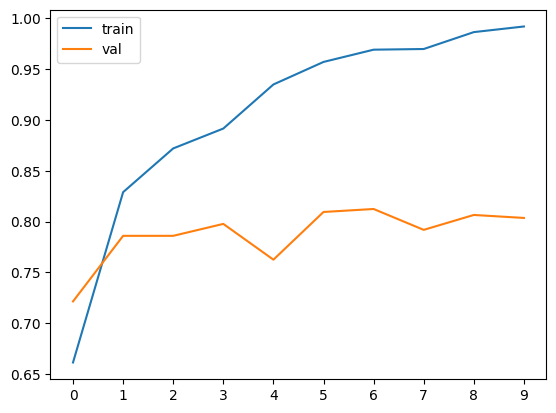

In [22]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

Adjusting the learning rate

In [23]:
# Function to create model
def make_model(learning_rate=0.01):
    base_model = Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(150,150,3))

    base_model.trainable = False
    
    #########################################
    
    inputs = keras.Input(shape=(150,150,3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    
    return model

In [24]:
# Dictionary to store history with different learning rates
scores = {}

# List of learning rates
lrs = [0.0001, 0.001, 0.01, 0.1]

for lr in lrs:
    print(lr)
    
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history
    
    print()
    print()

0.0001
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.3986 - loss: 1.8292 - val_accuracy: 0.4985 - val_loss: 1.5544
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5698 - loss: 1.3498 - val_accuracy: 0.6158 - val_loss: 1.2484
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6366 - loss: 1.1295 - val_accuracy: 0.6716 - val_loss: 1.0787
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6809 - loss: 0.9959 - val_accuracy: 0.7097 - val_loss: 0.9735
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7128 - loss: 0.9064 - val_accuracy: 0.7419 - val_loss: 0.9001
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7278 - loss: 0.8402 - val_accuracy: 0.7537 - val_loss: 0.8458
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7458 - loss: 0.7875 - val_accuracy: 0.7537 - val_loss: 0.8073
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7575 - loss: 0.7450 - val_accuracy: 0

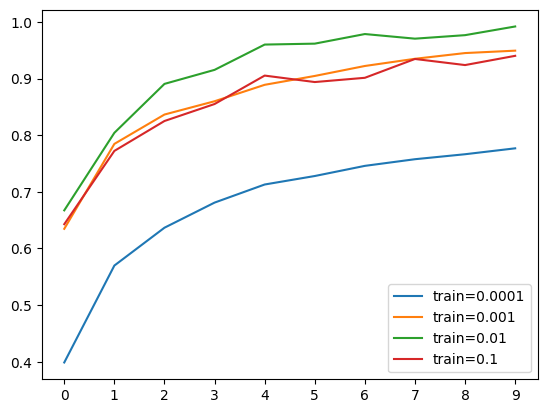

In [25]:
for lr, history in scores.items():
    # if lr == 0.0001 or lr == 0.1:
    #     continue
    plt.plot(history['accuracy'], label=f'train={lr}')
    # plt.plot(history['val_accuracy'], label=f'val={lr}')
plt.xticks(np.arange(10))
plt.legend()

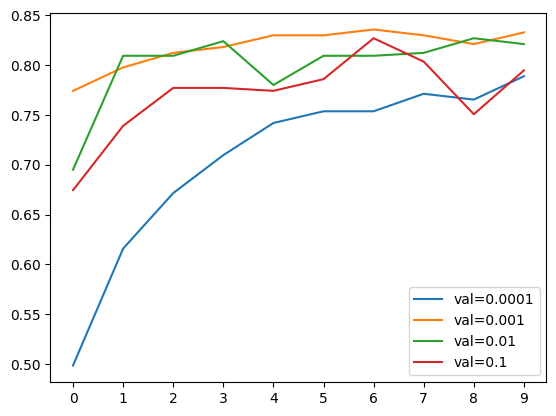

In [26]:
for lr, history in scores.items():
    # if lr == 0.0001 or lr == 0.1:
    #     continue
    # plt.plot(history['accuracy'], label=f'train={lr}')
    plt.plot(history['val_accuracy'], label=f'val={lr}')
plt.xticks(np.arange(10))
plt.legend()

In [27]:
learning_rate = 0.001

Checkpoints

In [28]:
model.save_weights(filepath='model_v1.weights.h5')

In [29]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [30]:
learning_rate = 0.001
 
model = make_model(learning_rate=learning_rate)
 
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5184 - loss: 1.4228

96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - accuracy: 0.6405 - loss: 1.0702 - val_accuracy: 0.7654 - val_loss: 0.7249
Epoch 2/10
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7899 - loss: 0.6365

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.7859 - loss: 0.6296 - val_accuracy: 0.7918 - val_loss: 0.6424
Epoch 3/10
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8467 - loss: 0.4803

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8289 - loss: 0.5046 - val_accuracy: 0.8035 - val_loss: 0.6001
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8615 - loss: 0.4256 - val_accuracy: 0.7947 - val_loss: 0.5820
Epoch 5/10
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8905 - loss: 0.3594

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8849 - loss: 0.3755 - val_accuracy: 0.8123 - val_loss: 0.5460
Epoch 6/10
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9010 - loss: 0.3343

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9035 - loss: 0.3239 - val_accuracy: 0.8328 - val_loss: 0.5424
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9218 - loss: 0.2866 - val_accuracy: 0.8182 - val_loss: 0.5496
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9332 - loss: 0.2606 - val_accuracy: 0.8240 - val_loss: 0.5460
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9433 - loss: 0.2330 - val_accuracy: 0.8299 - val_loss: 0.5440
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9511 - loss: 0.2068 - val_accuracy: 0.8152 - val_loss: 0.5398


Inner layer

In [31]:
# Function to define model by adding new dense layer
def make_model(learning_rate=0.01, size_inner=100): # default layer size is 100
    base_model = Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(150,150,3))

    base_model.trainable = False
    
    #########################################
    
    inputs = keras.Input(shape=(150,150,3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors) # activation function 'relu'
    outputs = keras.layers.Dense(10)(inner)
    model = keras.Model(inputs, outputs)
    
    #########################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    
    return model

In [32]:
# Experiement different number of inner layer with best learning rate
# Note: We should've added the checkpoint for training but for simplicity we are skipping it
learning_rate = 0.001

scores = {}

# List of inner layer sizes
sizes = [10, 100, 1000]

for size in sizes:
    print(size)
    
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history
    
    print()
    print()

10
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.4733 - loss: 1.5624 - val_accuracy: 0.6129 - val_loss: 1.1931
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6926 - loss: 0.9756 - val_accuracy: 0.7302 - val_loss: 0.8867
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7516 - loss: 0.7389 - val_accuracy: 0.7595 - val_loss: 0.7672
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7989 - loss: 0.6023 - val_accuracy: 0.7713 - val_loss: 0.7086
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8315 - loss: 0.5104 - val_accuracy: 0.7859 - val_loss: 0.6653
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8543 - loss: 0.4467 - val_accuracy: 0.7830 - val_loss: 0.6549
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8778 - loss: 0.3927 - val_accuracy: 0.7683 - val_loss: 0.6589
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8947 - loss: 0.3505 - val_accuracy: 0.785

2025-12-02 08:08:57.541293: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-02 08:08:58.453232: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4237', 68 bytes spill stores, 68 bytes spill loads



96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.6802 - loss: 0.9419 - val_accuracy: 0.7595 - val_loss: 0.6856
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8259 - loss: 0.5006 - val_accuracy: 0.7947 - val_loss: 0.6281
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8827 - loss: 0.3506 - val_accuracy: 0.7859 - val_loss: 0.5963
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9273 - loss: 0.2446 - val_accuracy: 0.7889 - val_loss: 0.6724
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9527 - loss: 0.1752 - val_accuracy: 0.8270 - val_loss: 0.5767
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9782 - loss: 0.1136 - val_accuracy: 0.8123 - val_loss: 0.5679
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9860 - loss: 0.0865 - val_accuracy: 0.8240 - val_loss: 0.5834
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9945 - loss: 0.0591 - val_accuracy: 0.8152 - val_loss: 

2025-12-02 08:09:49.754161: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-02 08:09:50.978890: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3793', 24 bytes spill stores, 24 bytes spill loads

2025-12-02 08:09:51.106396: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4237', 68 bytes spill stores, 68 bytes spill loads



67/96 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5442 - loss: 1.4159

2025-12-02 08:09:57.062434: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3800', 4 bytes spill stores, 4 bytes spill loads

2025-12-02 08:09:57.276103: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3793', 56 bytes spill stores, 56 bytes spill loads

2025-12-02 08:09:57.372162: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3800', 32 bytes spill stores, 32 bytes spill loads

2025-12-02 08:09:57.453038: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3800', 32 bytes spill stores, 32 bytes spill loads



96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5835 - loss: 1.2814

2025-12-02 08:10:05.416444: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1093', 4 bytes spill stores, 4 bytes spill loads

2025-12-02 08:10:05.643708: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1086', 56 bytes spill stores, 56 bytes spill loads

2025-12-02 08:10:05.675621: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1093', 32 bytes spill stores, 32 bytes spill loads

2025-12-02 08:10:05.691743: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1093', 32 bytes spill stores, 32 bytes spill loads



96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - accuracy: 0.6848 - loss: 0.9263 - val_accuracy: 0.7683 - val_loss: 0.6887
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8501 - loss: 0.4345 - val_accuracy: 0.7801 - val_loss: 0.6397
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9100 - loss: 0.2686 - val_accuracy: 0.7801 - val_loss: 0.6420
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9446 - loss: 0.1656 - val_accuracy: 0.8065 - val_loss: 0.6569
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9726 - loss: 0.0978 - val_accuracy: 0.8094 - val_loss: 0.6371
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9896 - loss: 0.0518 - val_accuracy: 0.8006 - val_loss: 0.7382
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9951 - loss: 0.0314 - val_accuracy: 0.8152 - val_loss: 0.6939
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9980 - loss: 0.0173 - val_accuracy: 0.8123 - val_loss: 

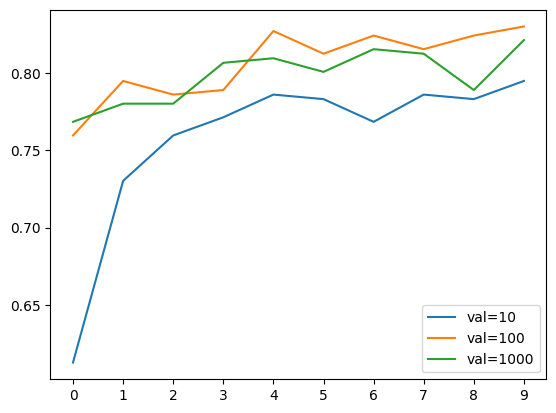

In [33]:
for size, history in scores.items():
    # if lr == 0.0001 or lr == 0.1:
    #     continue
    plt.plot(history['val_accuracy'], label=f'val={size}')
plt.xticks(np.arange(10))
plt.legend()

Dropout & Regularization

In [34]:
# Function to define model by adding new dense layer and dropout
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(150,150,3))

    base_model.trainable = False
    
    #########################################
    
    inputs = keras.Input(shape=(150,150,3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner) # add dropout layer
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)
    
    #########################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    
    return model


# Create checkpoint to save best model for version 3
filepath = './xception_v3_{epoch:02d}_{val_accuracy:.3f}.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                                             save_best_only=True,
                                             monitor='val_accuracy',
                                             mode='max')

# Set the best values of learning rate and inner layer size based on previous experiments
learning_rate = 0.001
size = 100

# Dict to store results
scores = {}

# List of dropout rates
droprates = [0.0, 0.2, 0.5, 0.8]

for droprate in droprates:
    print(droprate)
    
    model = make_model(learning_rate=learning_rate,
                       size_inner=size,
                       droprate=droprate)
    
    # Train for longer (epochs=30) cause of dropout regularization
    history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[checkpoint])
    scores[droprate] = history.history
    
    print()
    print()

0.0
Epoch 1/30
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5540 - loss: 1.3288

96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.6607 - loss: 0.9879 - val_accuracy: 0.7713 - val_loss: 0.6565
Epoch 2/30
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8356 - loss: 0.4984

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8227 - loss: 0.5113 - val_accuracy: 0.7918 - val_loss: 0.5835
Epoch 3/30
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8855 - loss: 0.3494

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8830 - loss: 0.3574 - val_accuracy: 0.8240 - val_loss: 0.5708
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9185 - loss: 0.2619 - val_accuracy: 0.8035 - val_loss: 0.5565
Epoch 5/30
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9545 - loss: 0.1858

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9544 - loss: 0.1782 - val_accuracy: 0.8299 - val_loss: 0.5588
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9716 - loss: 0.1283 - val_accuracy: 0.8240 - val_loss: 0.5685
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9837 - loss: 0.0874 - val_accuracy: 0.8270 - val_loss: 0.6222
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9964 - loss: 0.0576 - val_accuracy: 0.7977 - val_loss: 0.6564
Epoch 9/30
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9977 - loss: 0.0447

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9977 - loss: 0.0430 - val_accuracy: 0.8416 - val_loss: 0.5803
Epoch 10/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9987 - loss: 0.0293 - val_accuracy: 0.8416 - val_loss: 0.6147
Epoch 11/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9993 - loss: 0.0218 - val_accuracy: 0.8270 - val_loss: 0.6390
Epoch 12/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9990 - loss: 0.0184 - val_accuracy: 0.8299 - val_loss: 0.6380
Epoch 13/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9997 - loss: 0.0146 - val_accuracy: 0.8240 - val_loss: 0.6347
Epoch 14/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9997 - loss: 0.0124 - val_accuracy: 0.8299 - val_loss: 0.6473
Epoch 15/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9993 - loss: 0.0117 - val_accuracy: 0.8270 - val_loss: 0.6560
Epoch 16/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9993 - loss: 0.0128 - val_accuracy: 0.8328 - val_l

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9977 - loss: 0.0107 - val_accuracy: 0.8446 - val_loss: 0.7060
Epoch 21/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9993 - loss: 0.0061 - val_accuracy: 0.8152 - val_loss: 0.7015
Epoch 22/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9987 - loss: 0.0089 - val_accuracy: 0.8299 - val_loss: 0.6990
Epoch 23/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9993 - loss: 0.0073 - val_accuracy: 0.8240 - val_loss: 0.7314
Epoch 24/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9990 - loss: 0.0068 - val_accuracy: 0.8240 - val_loss: 0.7448
Epoch 25/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9993 - loss: 0.0078 - val_accuracy: 0.8123 - val_loss: 0.8234
Epoch 26/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9990 - loss: 0.0083 - val_accuracy: 0.8358 - val_loss: 0.7332
Epoch 27/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9984 - loss: 0.0073 - val_accuracy: 0.8270 - val_l

96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9958 - loss: 0.0231 - val_accuracy: 0.8475 - val_loss: 0.6490
Epoch 26/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9980 - loss: 0.0150 - val_accuracy: 0.8416 - val_loss: 0.7314
Epoch 27/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9990 - loss: 0.0102 - val_accuracy: 0.8358 - val_loss: 0.7002
Epoch 28/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9974 - loss: 0.0183 - val_accuracy: 0.8240 - val_loss: 0.7232
Epoch 29/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9964 - loss: 0.0187 - val_accuracy: 0.8270 - val_loss: 0.7405
Epoch 30/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9954 - loss: 0.0210 - val_accuracy: 0.8065 - val_loss: 0.9169


0.5
Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.5909 - loss: 1.2293 - val_accuracy: 0.7419 - val_loss: 0.7505
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7249 - loss: 0.8082 - val_accuracy: 0.7918 -

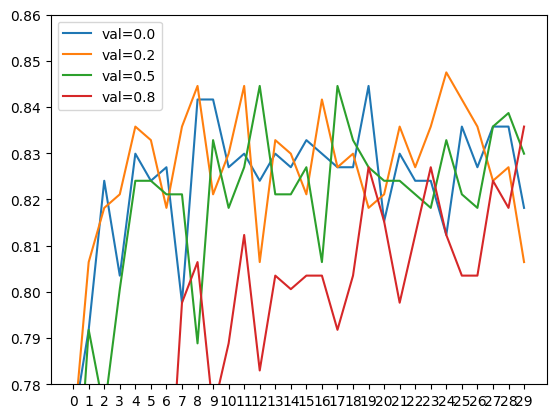

In [35]:
for rate, history in scores.items():
    plt.plot(history['val_accuracy'], label=f'val={rate}')
plt.xticks(np.arange(30))
plt.ylim(0.78, 0.86)
plt.legend()

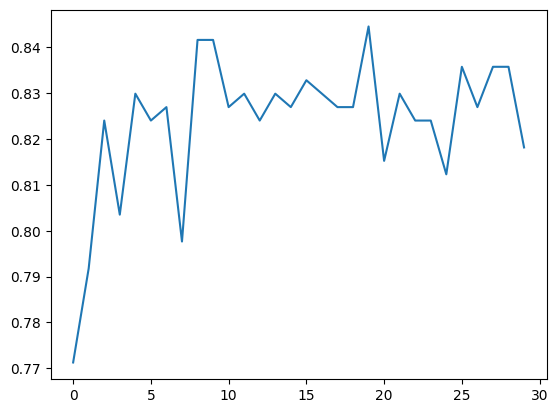

In [36]:
rate = 0.0
hist = scores[rate]
plt.plot(hist['val_accuracy'], label=f'val={rate}')
# plt.plot(hist['accuracy'], label=f'train={rate}')

Data augmentation

In [37]:
# Build image generator for training (takes preprocessing input function)
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                            #    rotation_range=30,
                            #    width_shift_range=10.0,
                            #    height_shift_range=10.0,
                               shear_range=10,
                               zoom_range=0.1,
                               vertical_flip=True)

# Load in train dataset into train generator
train_ds = train_gen.flow_from_directory(directory='clothing-dataset-small-master/train', # Train images directory
                                         target_size=(150,150), # resize images to train faster
                                         batch_size=32) # 32 images per batch

# Create image generator for validation
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load in image for validation
val_ds = val_gen.flow_from_directory(directory='clothing-dataset-small-master/validation', # Validation image directory
                                     target_size=(150,150),
                                     batch_size=32,
                                     shuffle=False) # False for validation

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [38]:
# Set the best values of learning rate and inner layer size based on previous experiments
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(learning_rate=learning_rate,
                    size_inner=size,
                    droprate=droprate)

# Train for longer (epochs=30) cause of dropout regularization
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.5655 - loss: 1.3171 - val_accuracy: 0.7595 - val_loss: 0.7587
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.6816 - loss: 0.9171 - val_accuracy: 0.7625 - val_loss: 0.6763
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.7314 - loss: 0.7864 - val_accuracy: 0.7977 - val_loss: 0.5860
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.7539 - loss: 0.7140 - val_accuracy: 0.7859 - val_loss: 0.5941
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.7891 - loss: 0.6380 - val_accuracy: 0.8006 - val_loss: 0.6091
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.7999 - loss: 0.5764 - val_accuracy: 0.8065 - val_loss: 0.5750
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.7999 - loss: 0.5795 - val_accuracy: 0.8035 - val_loss: 0.5678
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.8155 - loss: 0.5280 - val_accu

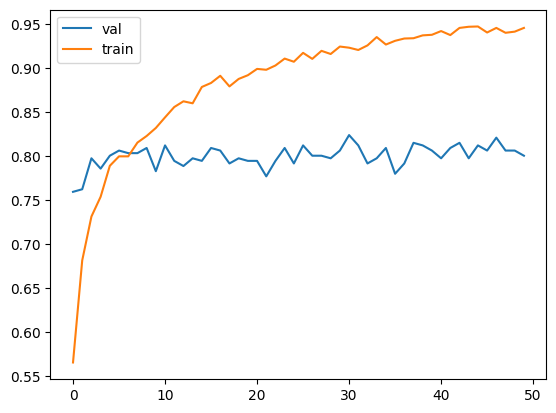

In [39]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')
 
plt.legend()

Training a larger model

In [4]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):
 
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )
 
    base_model.trainable = False
 
    #########################################
 
    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
     
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
     
    outputs = keras.layers.Dense(10)(drop)
     
    model = keras.Model(inputs, outputs)
     
    #########################################
 
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
 
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
     
    return model

In [5]:
input_size = 299

In [8]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)
 
train_ds = train_gen.flow_from_directory(
    'clothing-dataset-small-master/train',
    target_size=(input_size, input_size),
    batch_size=32
)
 
 
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
 
val_ds = train_gen.flow_from_directory(
    'clothing-dataset-small-master/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [9]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [12]:
learning_rate = 0.001
size = 100
droprate = 0.2
 
model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)
 
history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])

I0000 00:00:1764664615.939447   81127 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10135 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:26:00.0, compute capability: 8.9


Epoch 1/50


2025-12-02 08:37:01.412061: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fd998002ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-02 08:37:01.412080: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-12-02 08:37:01.477934: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-02 08:37:02.214508: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-02 08:37:02.360220: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-02 08:37:03.296964: I e

35/96 ━━━━━━━━━━━━━━━━━━━━ 22s 375ms/step - accuracy: 0.5088 - loss: 1.5679

2025-12-02 08:37:34.365954: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:37:34.467442: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:37:35.789293: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:37:35.920213: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:37:37.660660: E external/local_xla/xla/stream_

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.6282 - loss: 1.1864

2025-12-02 08:38:23.138135: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:38:23.236167: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:38:24.257147: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:38:24.380895: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 08:38:25.700439: E external/local_xla/xla/stream_

96/96 ━━━━━━━━━━━━━━━━━━━━ 97s 807ms/step - accuracy: 0.7347 - loss: 0.8331 - val_accuracy: 0.8358 - val_loss: 0.4778
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8356 - loss: 0.4672

96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 427ms/step - accuracy: 0.8416 - loss: 0.4568 - val_accuracy: 0.8475 - val_loss: 0.4356
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8686 - loss: 0.3822

96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 448ms/step - accuracy: 0.8713 - loss: 0.3706 - val_accuracy: 0.8651 - val_loss: 0.4236
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8758 - loss: 0.3553

96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 430ms/step - accuracy: 0.8745 - loss: 0.3514 - val_accuracy: 0.8710 - val_loss: 0.3913
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8983 - loss: 0.3233

96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 434ms/step - accuracy: 0.8986 - loss: 0.3082 - val_accuracy: 0.8827 - val_loss: 0.3523
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 418ms/step - accuracy: 0.8990 - loss: 0.2801 - val_accuracy: 0.8739 - val_loss: 0.3791
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 429ms/step - accuracy: 0.9071 - loss: 0.2606 - val_accuracy: 0.8739 - val_loss: 0.3892
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 401ms/step - accuracy: 0.9156 - loss: 0.2376 - val_accuracy: 0.8622 - val_loss: 0.4203
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 416ms/step - accuracy: 0.9270 - loss: 0.2112 - val_accuracy: 0.8680 - val_loss: 0.3940
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 38s 399ms/step - accuracy: 0.9260 - loss: 0.2084 - val_accuracy: 0.8592 - val_loss: 0.4079
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 427ms/step - accuracy: 0.9358 - loss: 0.1877 - val_accuracy: 0.8710 - val_loss: 0.3868
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9438 - loss: 0.1614

96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 408ms/step - accuracy: 0.9423 - loss: 0.1653 - val_accuracy: 0.8886 - val_loss: 0.3635
Epoch 13/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 429ms/step - accuracy: 0.9397 - loss: 0.1700 - val_accuracy: 0.8886 - val_loss: 0.4065
Epoch 14/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 415ms/step - accuracy: 0.9485 - loss: 0.1497 - val_accuracy: 0.8856 - val_loss: 0.4156
Epoch 15/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 419ms/step - accuracy: 0.9498 - loss: 0.1460 - val_accuracy: 0.8622 - val_loss: 0.3970
Epoch 16/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 422ms/step - accuracy: 0.9580 - loss: 0.1345 - val_accuracy: 0.8886 - val_loss: 0.3830
Epoch 17/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 430ms/step - accuracy: 0.9534 - loss: 0.1309 - val_accuracy: 0.8827 - val_loss: 0.3983
Epoch 18/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9590 - loss: 0.1237

96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 407ms/step - accuracy: 0.9557 - loss: 0.1337 - val_accuracy: 0.8915 - val_loss: 0.3574
Epoch 19/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 442ms/step - accuracy: 0.9593 - loss: 0.1197 - val_accuracy: 0.8856 - val_loss: 0.4218
Epoch 20/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 430ms/step - accuracy: 0.9635 - loss: 0.1075 - val_accuracy: 0.8592 - val_loss: 0.3782
Epoch 21/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step - accuracy: 0.9654 - loss: 0.1069 - val_accuracy: 0.8915 - val_loss: 0.3833
Epoch 22/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 431ms/step - accuracy: 0.9668 - loss: 0.0996 - val_accuracy: 0.8739 - val_loss: 0.3846
Epoch 23/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 422ms/step - accuracy: 0.9710 - loss: 0.0940 - val_accuracy: 0.8475 - val_loss: 0.4552
Epoch 24/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 432ms/step - accuracy: 0.9726 - loss: 0.0915 - val_accuracy: 0.8622 - val_loss: 0.4528
Epoch 25/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 418ms/step - accuracy: 0.9726 - loss: 0.0881 - val_accuracy

96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 434ms/step - accuracy: 0.9765 - loss: 0.0782 - val_accuracy: 0.8944 - val_loss: 0.3858
Epoch 29/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step - accuracy: 0.9817 - loss: 0.0665 - val_accuracy: 0.8563 - val_loss: 0.4707
Epoch 30/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 420ms/step - accuracy: 0.9765 - loss: 0.0734 - val_accuracy: 0.8856 - val_loss: 0.4900
Epoch 31/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 412ms/step - accuracy: 0.9759 - loss: 0.0692 - val_accuracy: 0.8856 - val_loss: 0.4587
Epoch 32/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 423ms/step - accuracy: 0.9840 - loss: 0.0642 - val_accuracy: 0.8680 - val_loss: 0.4562
Epoch 33/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 428ms/step - accuracy: 0.9814 - loss: 0.0556 - val_accuracy: 0.8798 - val_loss: 0.4568
Epoch 34/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 428ms/step - accuracy: 0.9831 - loss: 0.0562 - val_accuracy: 0.8710 - val_loss: 0.4355
Epoch 35/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 467ms/step - accuracy: 0.9827 - loss: 0.0571 - val_accuracy

Using the model

In [13]:
import tensorflow as tf
from tensorflow import keras
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import preprocess_input

In [15]:
# Loading the model
model = keras.models.load_model('xception_v4_28_0.894.h5')

In [16]:
# Load the test dataset
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
 
test_ds = test_gen.flow_from_directory(
    'clothing-dataset-small-master/validation',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 341 images belonging to 10 classes.


In [17]:
model.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 663ms/step - accuracy: 0.8915 - loss: 0.4148


[0.4148244559764862, 0.8914955854415894]

Getting predictions

In [19]:
import numpy as np
 
path = 'clothing-dataset-small-master/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'
 
img = load_img(path, target_size=(299, 299))
 
x = np.array(img)
X = np.array([x])
X.shape
 
# Output: (1, 299, 299, 3)
 
X = preprocess_input(X)
pred = model.predict(X)

2025-12-02 09:40:26.707320: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 09:40:26.788717: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 09:40:27.208130: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 09:40:27.284452: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 09:40:27.744168: E external/local_xla/xla/stream_

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


In [20]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]
 
dict(zip(classes, pred[0]))

{'dress': np.float32(-5.734263),
 'hat': np.float32(-6.310942),
 'longsleeve': np.float32(-0.7150105),
 'outwear': np.float32(-3.3594372),
 'pants': np.float32(13.114514),
 'shirt': np.float32(-3.727416),
 'shoes': np.float32(-5.925156),
 'shorts': np.float32(4.1214094),
 'skirt': np.float32(-8.209652),
 't-shirt': np.float32(-2.8736572)}